In [1]:
import pandas as pd
import numpy as np
import os
import sys
import math
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import pyarrow
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, hour, dayofweek, when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.clustering import KMeans

### Create Spark Session

In [2]:

spark = SparkSession.builder \
    .appName("EcommercePriceApp") \
    .config("spark.sql.warehouse.dir", "hdfs://localhost:9000/user/hive/warehouse") \
    .config("hive.metastore.uris", "thrift://localhost:9083") \
    .enableHiveSupport() \
    .getOrCreate()

In [2]:
# Initialize Spark session

#spark = SparkSession.builder.appName("Recommendation_engine").getOrCreate()
spark = SparkSession.builder.appName("Product_Recommendation") \
.config ("spark.sql.shuffle.partitions", "16") \
.config("spark.driver.maxResultSize","4g") \
.config ("spark.sql.execution.arrow.enabled", "true") \
.config("spark.driver.memory", "4g") \
.config("spark.executor.cores", "4") \
.config("spark.sql.catalogImplementation", "hive") \
.config("spark.sql.warehouse.dir","hdfs://localhost:9000/explorer.html#/user/hive/warehouse") \
.config("hive.metastore.uris", "thrift://localhost:9083") \
.enableHiveSupport() \
.getOrCreate()


spark.sparkContext.setLogLevel("ERROR")

### Load Data

In [5]:
spark.sql("use tradedb")
df = spark.sql('select * from sessions where event_type in (\'purchase\',\'cart\',\'view\') limit 10000')
# Print DataFrame schema
df.printSchema()
df = df.drop(df.columns[0])
data=df.dropna()
# Show first 5 rows of the DataFrame
data.show(5, truncate=False)

root
 |-- event_time: date (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)

+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|event_type|product_id|category_id        |category_code                      |brand   |price  |user_id  |user_session                        |
+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|view      |44600062  |2103807459595387724|                                   |shiseido|35.79  |541312140|72d76fde-8bb3-4e00-8c23-a032dfed738c|
|view      |3900821   |2053013552326770905|appli

In [3]:
data = spark.read.csv("hdfs://localhost:9000/project_files/2019-Nov.csv", header=True, inferSchema=True)

# spark.sql("USE ecommerce")
#data = spark.sql('select * from ecommerce.purchases')
# Print DataFrame schema
data.printSchema()
data = data.dropna()
# Show first 10 rows of the DataFrame
data.show(5, truncate=False)

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

+-------------------+----------+----------+-------------------+-------------------------+------+------+---------+------------------------------------+
|event_time         |event_type|product_id|category_id        |category_code            |brand |price |user_id  |user_session                        |
+-------------------+----------+----------+-------------------+-------------------------+------+------+---------+------------------------------------+
|2019-11-01 02:00:00|view      |1003461   |2053013555631882655|electronics.smartphone   |xiaomi|489.07|520088904|4d3b30da-a5e4-49df-b1a8-ba5943f1dd33|
|2019-11-01 02:0

### Exploratory Data Analysis

In [6]:
# Number of events

data.groupBy('event_type').count().show()

+----------+-----+
|event_type|count|
+----------+-----+
|      view| 9785|
|  purchase|  118|
|      cart|   97|
+----------+-----+



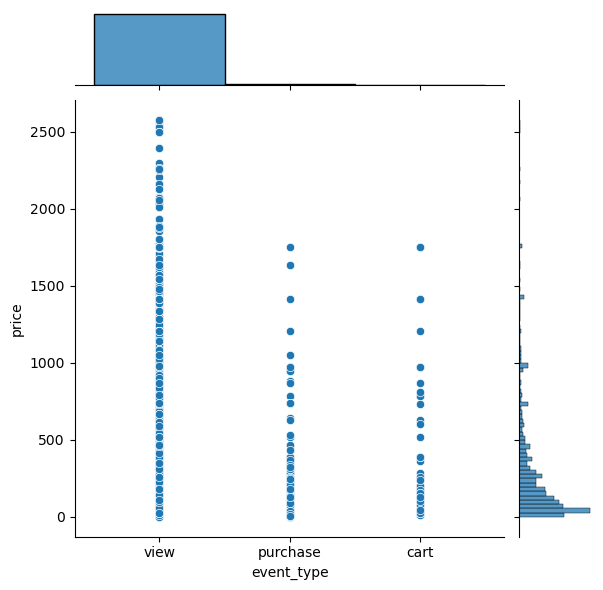

In [9]:
# Convert Spark DataFrame to Pandas for visualization
pandas_df = data.toPandas()

# Create jointplots
import seaborn as sns

sns.jointplot(data=pandas_df, x='event_type', y='price')
plt.show()



<Axes: ylabel='count'>

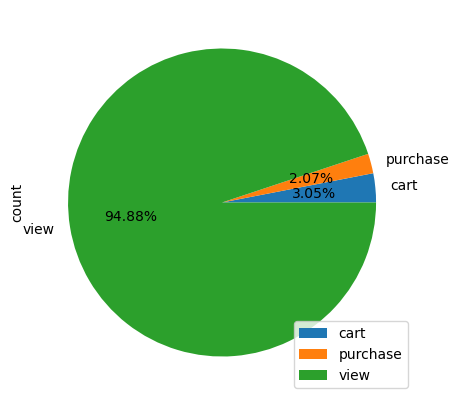

In [5]:
# Plot events distribution
events = data.groupBy('event_type').count().toPandas()
events.plot(kind='pie', y='count', labels=events['event_type'], autopct='%1.2f%%', figsize=(5, 5))

In [ ]:
sns.jointplot(x='category_code', y='price', data=pandas_df)
plt.show()

sns.jointplot(x='category_code', y='lengthofmembership', kind='hex', data=pandas_df)
plt.show()

sns.pairplot(pandas_df)
plt.show()

sns.lmplot(x='user_id', y='price', data=pandas_df)
plt.show()

In [11]:
# Number of events

brand_count_df = data.groupBy('brand').count()
brand_count_df.show()

+--------+-----+
|   brand|count|
+--------+-----+
|shiseido|    2|
|    aqua|    2|
|        | 1442|
|  lenovo|   95|
|   apple| 1039|
|  pulser|   30|
|   creed|    2|
|luminarc|   48|
|   baden|   23|
|  huawei|  306|
|elenberg|  102|
| samsung| 1231|
|   haier|   17|
|     brw|   47|
|   bosch|  118|
|      hp|   89|
|     jbl|   17|
|  xiaomi|  698|
|   midea|   28|
| ariston|   29|
+--------+-----+
only showing top 20 rows



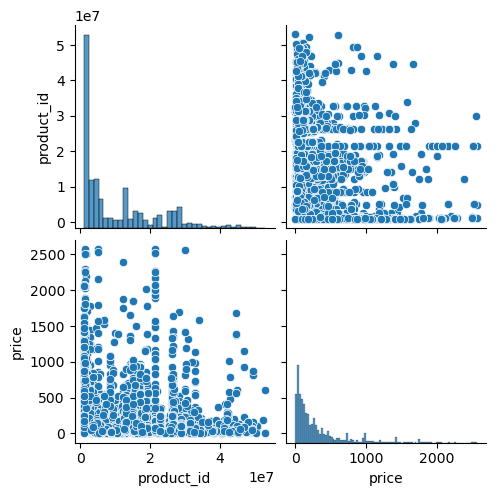

In [14]:
sns.pairplot(pandas_df)
plt.show()

In [6]:
# Filter data to include only certain event types
purchase_df = data.filter(data["event_type"].isin("purchase"))

# Count the number of records after filtering
purchase_df.count()
# Show first 10 rows of the DataFrame
purchase_df.show(10, truncate=False)

+-------------------+----------+----------+-------------------+---------------------------------+-------+------+---------+------------------------------------+
|event_time         |event_type|product_id|category_id        |category_code                    |brand  |price |user_id  |user_session                        |
+-------------------+----------+----------+-------------------+---------------------------------+-------+------+---------+------------------------------------+
|2019-10-01 02:02:14|purchase  |1004856   |2053013555631882655|electronics.smartphone           |samsung|130.76|543272936|8187d148-3c41-46d4-b0c0-9c08cd9dc564|
|2019-10-01 02:04:37|purchase  |1002532   |2053013555631882655|electronics.smartphone           |apple  |642.69|551377651|3c80f0d6-e9ec-4181-8c5c-837a30be2d68|
|2019-10-01 02:07:07|purchase  |13800054  |2053013557418656265|furniture.bathroom.toilet        |santeri|54.42 |555332717|1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f|
|2019-10-01 02:09:26|purchase  |4804055 

In [21]:
# Convert category_id to integer
data = data.withColumn("product_id", col("product_id").cast(IntegerType()))
data = data.withColumn("category_id", col("category_id").cast(IntegerType()))
data = data.withColumn("user_id  ", col("user_id  ").cast(IntegerType()))

NameError: name 'IntegerType' is not defined

### Regression

In [20]:
# Prepare features
#feature_columns = ['product_id', 'user_id', 'price']
# Identify numeric columns
numeric_columns = [field.name for field in data.schema.fields if isinstance(field.dataType, DoubleType)]

print("Numeric columns:", numeric_columns)
target_column = 'price'
feature_columns = [col for col in numeric_columns if col != target_column]
data_clean = data.dropna(subset=feature_columns + [target_column])
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
data_assembled = assembler.transform(data_clean)

# Split the data
(training_data, test_data) = data_assembled.randomSplit([0.7, 0.3], seed=101)

# Create and train the model
lr = LinearRegression(featuresCol="features", labelCol="price")
model = lr.fit(training_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Print coefficients and intercept
print("Coefficients: ")
for feature, coef in zip(feature_columns, model.coefficients):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept}")

# Calculate R-squared
r2 = model.summary.r2
print(f"R-squared: {r2}")

Numeric columns: ['price']
Root Mean Squared Error (RMSE) on test data = 368.06236179573216
Coefficients: 
Intercept: 293.254414090583
R-squared: 4.884981308350689e-15


In [16]:
# Define categorical columns
categorical_cols = ["category_id", "category_code", "brand"]

# Indexers for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="skip") for col in categorical_cols]

# One-hot encoders for indexed categorical columns
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_ohe") for col in categorical_cols]

# Prepare features and label columns
feature_cols = ["product_id"] + [col+"_ohe" for col in categorical_cols]

# Assembler to combine features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features" , handleInvalid="skip")

# Combine all stages into a pipeline
stages = indexers + encoders + [assembler]

pipeline = Pipeline(stages=stages)

# Fit and transform the data
df_transformed = pipeline.fit(data).transform(data)

# Split the data into training and testing sets
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Select relevant columns
result = predictions.select("product_id", "category_id", "category_code", "brand", "price", "prediction")

# Show the results
result.show()

# Evaluate the model
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")

# Evaluate the RMSE
rmse = evaluator.evaluate(predictions)

# Evaluate the R-squared
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

IllegalArgumentException: requirement failed: Cannot have an empty string for name.

In [9]:
# Stop SparkSession
#spark.stop()

In [10]:

# Handle missing values by filling them with 'unknown'
data = data.fillna({'category_code': 'unknown', 'brand': 'unknown'})

# Extract hour and day of week from event_time
data = data.withColumn("hour", hour(col("event_time")))
data = data.withColumn("day_of_week", dayofweek(col("event_time")))

# Encode categorical features using StringIndexer
indexer_category = StringIndexer(inputCol="category_code", outputCol="category_code_index")
indexer_brand = StringIndexer(inputCol="brand", outputCol="brand_index")
data = indexer_category.fit(data).transform(data)
data = indexer_brand.fit(data).transform(data)

# Select features and target
features = ['product_id', 'category_id', 'category_code_index', 'brand_index', 'price', 'hour', 'day_of_week']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Encode target variable
indexer_event_type = StringIndexer(inputCol="event_type", outputCol="label")
data = indexer_event_type.fit(data).transform(data)

# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Train the model
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.2f}")

# Show classification report
predictions.select("product_id", "event_type", "prediction", "probability").show(15)

# Stop the Spark session
# spark.stop()


Test Accuracy: 0.95
+----------+----------+----------+--------------------+
|product_id|event_type|prediction|         probability|
+----------+----------+----------+--------------------+
|   1004237|      view|       0.0|[0.92507588486313...|
|   1005011|      view|       0.0|[0.92008680244296...|
|   3900746|      view|       0.0|[0.94135493273706...|
|   1306631|      view|       0.0|[0.91867496767961...|
|   1003306|      view|       0.0|[0.91193060011800...|
|   3701388|      view|       0.0|[0.92401689726246...|
|   3701244|      view|       0.0|[0.92198519165142...|
|   4803399|      view|       0.0|[0.93184344334205...|
|   4802639|      view|       0.0|[0.92952686313416...|
|   3701062|      view|       0.0|[0.94281576802930...|
|   3900930|      view|       0.0|[0.98601095076373...|
|   1004870|      view|       0.0|[0.90219318145751...|
|   1004856|      view|       0.0|[0.89700995953169...|
|   1004836|      view|       0.0|[0.90070487024270...|
|   1004785|      view|     

Clustering

In [ ]:
# Drop rows with any missing values
data = data.dropna()

# Indexing categorical columns
indexer = StringIndexer(inputCols=["event_type", "category_code", "brand"], outputCols=["event_type_index", "category_code_index", "brand_index"])
df_indexed = indexer.fit(data).transform(data)

# Assemble features
assembler = VectorAssembler(inputCols=["product_id", "category_id", "price", "user_id", "event_type_index", "category_code_index", "brand_index"], outputCol="features")
df_features = assembler.transform(df_indexed)

# KMeans model
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(df_features)

# Make predictions
predictions = model.transform(df_features)

# Show the result
predictions.show(15, truncate=False)

# Stop the Spark session
# spark.stop()